In [1]:
%pylab inline
import pandas as pd
import anndata

Populating the interactive namespace from numpy and matplotlib


/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
adata = anndata.read_loom('l6_r3_spinal_cord_neurons.loom', sparse=True)

In [5]:
counts = np.array(adata.X.todense()).astype(int)

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
expression_train, expression_test = train_test_split(counts)

In [9]:
%load_ext autoreload
%autoreload 2
import scVI
import tensorflow as tf
from helper import *

In [10]:
log_library_size = np.log(np.sum(expression_train, axis=1))
mean, var = np.mean(log_library_size), np.var(log_library_size)

batch_size = 128
learning_rate = 0.001
epsilon = 0.01

In [11]:
tf.reset_default_graph()
expression = tf.placeholder(tf.float32, (None, expression_train.shape[1]), name='x')
kl_scalar = tf.placeholder(tf.float32, (), name='kl_scalar')
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate, epsilon=epsilon)
training_phase = tf.placeholder(tf.bool, (), name='training_phase')

# getting priors
log_library_size = np.log(np.sum(expression_train, axis=1))
mean, var = np.mean(log_library_size), np.var(log_library_size)

# loading data
model = scVI.scVIModel(expression=expression, kl_scale=kl_scalar, \
                         optimize_algo=optimizer, phase=training_phase, \
                          library_size_mean=mean, library_size_var=var)

#starting computing session
sess = tf.Session()

Running scVI on 27998 genes
scVI will run without batch correction
Will work on mode numeric for incorporating library size
Will work on mode gene for modeling inverse dispersion param
Will apply zero inflation
1 hidden layers at 128 each for a final 10 latent space


In [12]:
# start a new graph and fit the training set
sess.run(tf.global_variables_initializer())
result = train_model(model, (expression_train, expression_test), sess, 250)

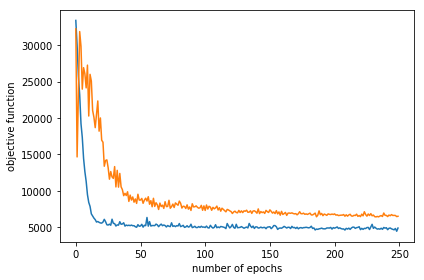

In [13]:
plot_training_info(result)

In [14]:
dic_full = {expression: counts, training_phase:False}
latent = sess.run(model.z, feed_dict=dic_full)

In [15]:
latent.shape

(1922, 10)

In [16]:
from sklearn.manifold import TSNE
tsne = TSNE(verbose=1)

In [17]:
YY = tsne.fit_transform(latent)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1922 samples in 0.001s...
[t-SNE] Computed neighbors for 1922 samples in 0.089s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1922
[t-SNE] Computed conditional probabilities for sample 1922 / 1922
[t-SNE] Mean sigma: 1.070046
[t-SNE] KL divergence after 250 iterations with early exaggeration: 67.519318
[t-SNE] Error after 1000 iterations: 0.798253


In [18]:
adata.obs['TSNE_1'] = YY[:, 0]
adata.obs['TSNE_2'] = YY[:, 1]

In [19]:
import plotnine as p

/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


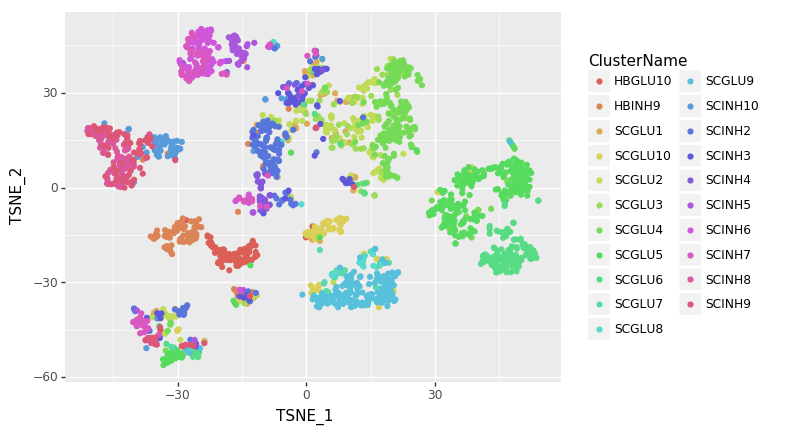

<ggplot: (-9223372036519249194)>

In [20]:
p.qplot('TSNE_1', 'TSNE_2', adata.obs, color='ClusterName')

In [21]:
adata.obs[['TSNE_1', 'TSNE_2', 'ClusterName']].to_csv('scVI_Zeisel_results.csv')